In [29]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from medmnist import INFO, ChestMNIST
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

In [12]:
# Dataset Configuration
data_flag = 'chestmnist'
info = INFO[data_flag]

In [13]:
# Load the dataset
train_dataset = ChestMNIST(split='train', download=True)
val_dataset = ChestMNIST(split='val', download=True)
test_dataset = ChestMNIST(split='test', download=True)

X_train, X_val, X_test = train_dataset.imgs, val_dataset.imgs, test_dataset.imgs


Using downloaded and verified file: C:\Users\areeb\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\areeb\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\areeb\.medmnist\chestmnist.npz


In [14]:
# Convert multi-label data to binary (0 or 1)
def convert2Binary(labels):
    """
    Convert multi-label data to binary (0 or 1).
    If any label is > 0, classify the image as 1 (positive), otherwise 0 (negative).
    """
    return np.where(labels.sum(axis=1) > 0, 1, 0)

# Apply binary conversion to labels
y_train = convert2Binary(train_dataset.labels)
y_val = convert2Binary(val_dataset.labels)
y_test = convert2Binary(test_dataset.labels)


In [15]:
# Verify dimensions
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (78468, 28, 28), y_train shape: (78468,)
X_val shape: (11219, 28, 28), y_val shape: (11219,)
X_test shape: (22433, 28, 28), y_test shape: (22433,)


In [16]:
# Normalize pixel values
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

In [17]:
# Add channel dimension for CNN
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

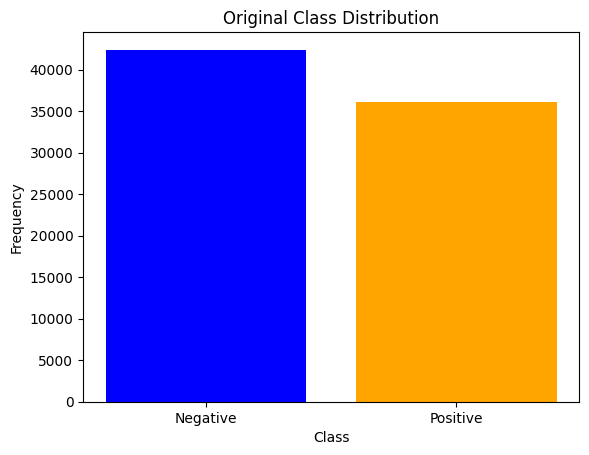

In [18]:
# Visualize Class Distribution
def plot_class_distribution(labels, title="Class Distribution"):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, color=['blue', 'orange'])
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(unique, ['Negative', 'Positive'])
    plt.show()

plot_class_distribution(y_train, title="Original Class Distribution")


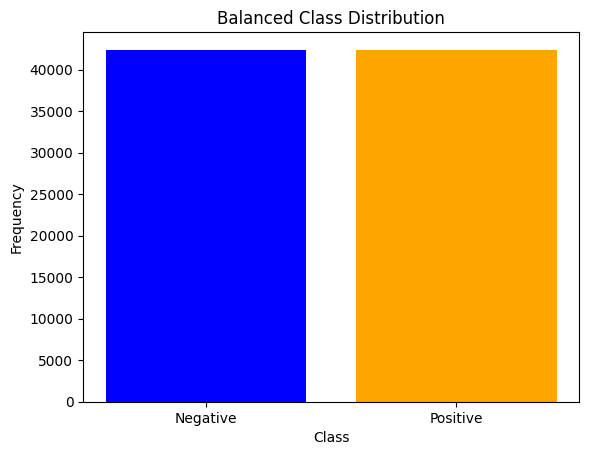

In [20]:
# Rebalance the Dataset (Over-sampling minority class)
def rebalance_data(X, y):
    X_negative = X[y == 0]
    y_negative = y[y == 0]
    X_positive = X[y == 1]
    y_positive = y[y == 1]
    
    # Over-sample positive class
    X_positive_oversampled, y_positive_oversampled = resample(
        X_positive, y_positive,
        replace=True,
        n_samples=len(y_negative),  # Match the majority class size
        random_state=42
    )
    
    # Combine oversampled positive and negative samples
    X_balanced = np.vstack((X_negative, X_positive_oversampled))
    y_balanced = np.hstack((y_negative, y_positive_oversampled))
    
    # Shuffle the dataset
    indices = np.arange(len(y_balanced))
    np.random.shuffle(indices)
    return X_balanced[indices], y_balanced[indices]

X_train_balanced, y_train_balanced = rebalance_data(X_train, y_train)
plot_class_distribution(y_train_balanced, title="Balanced Class Distribution")

In [21]:
# Define CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\areeb\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Train the Model
history = model.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.6046 - loss: 0.6972 - val_accuracy: 0.6188 - val_loss: 0.6610
Epoch 2/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6446 - loss: 0.6437 - val_accuracy: 0.6419 - val_loss: 0.6472
Epoch 3/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.6549 - loss: 0.6315 - val_accuracy: 0.6520 - val_loss: 0.6459
Epoch 4/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.6646 - loss: 0.6261 - val_accuracy: 0.6159 - val_loss: 0.6637
Epoch 5/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.6673 - loss: 0.6229 - val_accuracy: 0.6367 - val_loss: 0.6748
Epoch 6/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.6734 - loss: 0.6146 - val_accuracy: 0.6464 - val_loss: 0.6380
Epoch 7/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.6808 - loss: 0.6074 - val_accuracy: 0.6353 - val_loss: 0.6502
Epoch 8/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.6848 - lo

In [23]:
# Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}")

Test Accuracy: 0.66


702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


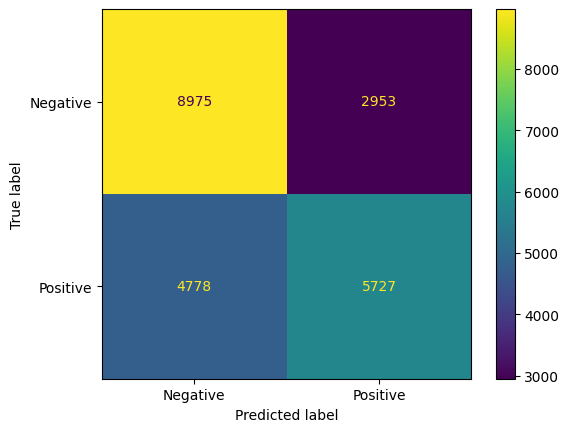

In [24]:
# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary, display_labels=['Negative', 'Positive'])
plt.show()

In [25]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary, target_names=['Negative', 'Positive']))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.75      0.70     11928
    Positive       0.66      0.55      0.60     10505

    accuracy                           0.66     22433
   macro avg       0.66      0.65      0.65     22433
weighted avg       0.66      0.66      0.65     22433



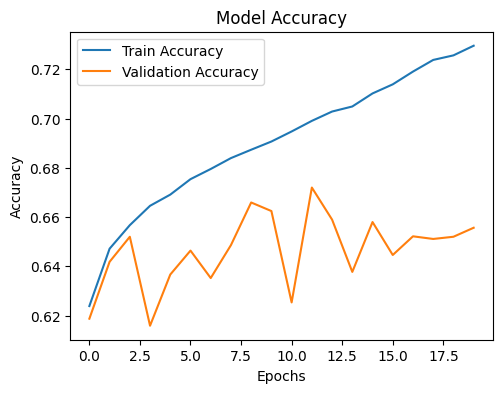

In [26]:
# Training History Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

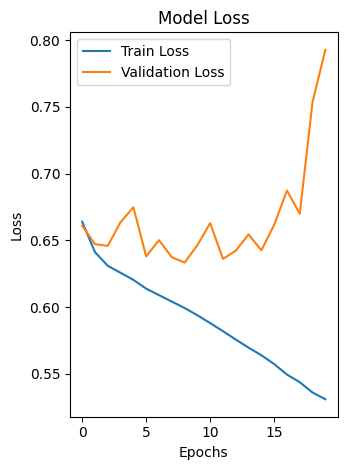

In [27]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

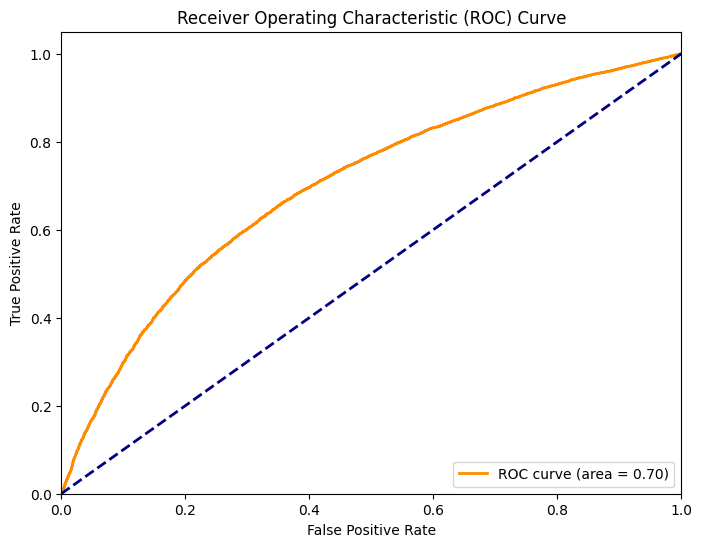

In [30]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

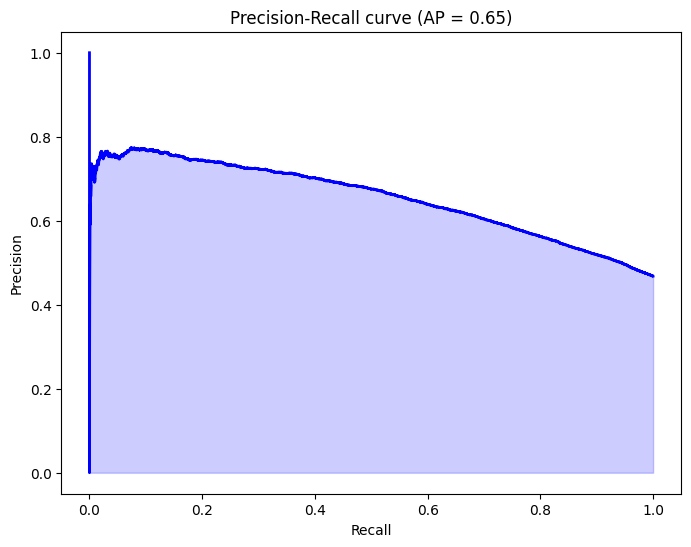

In [31]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.fill_between(recall, precision, color='b', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.show()

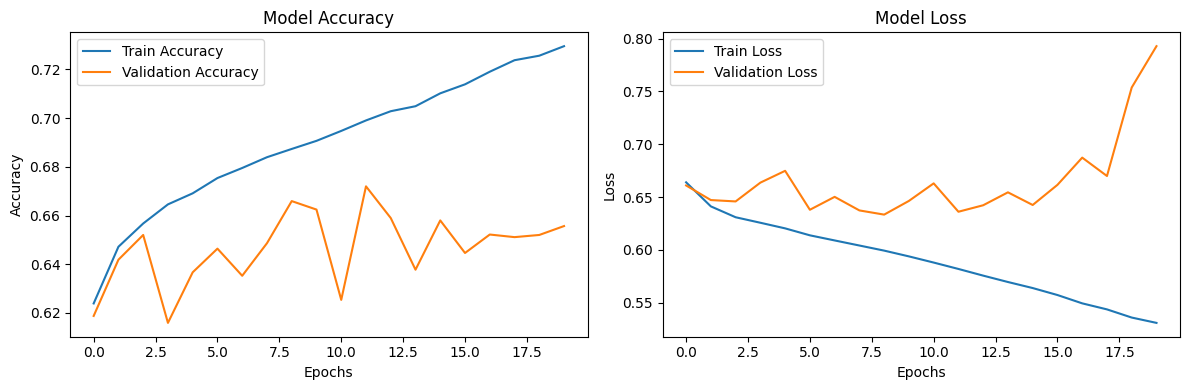

In [32]:
# Training History Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()